In [1]:
# from google.colab import drive
# drive.mount('/content/drive')

In [1]:
#install latest library
import os

# os.chdir('/content/drive/MyDrive/voxelmorph_swin_unet_new')

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib
import matplotlib.pyplot as plt
import os 
import sys
import random
plt.style.use("ggplot")
%matplotlib inline
import cv2
import torch
import torch.nn as nn

In [29]:
#!/usr/bin/python  
from cremi import Annotations, Volume
from cremi import CremiFile

import numpy as np
import random

# Open a file for reading
file = CremiFile.CremiFile("/home/kunzixie/Medical_Image_Analysis/voxelmorph_swin_unet_new/cremi/sample_C_20160501.hdf", "r")
 
# Read the file  
raw = file.read_raw()
neuron_ids = file.read_neuron_ids() 

# Read the data
raw_data=raw.data
label = neuron_ids.data

/tmp/ipykernel_37083/1921425872.py:2: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.
  plt.show()


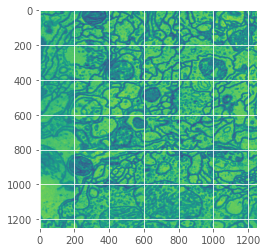

In [30]:
plt.imshow(raw_data[0])
plt.show()

/tmp/ipykernel_37083/1675844954.py:2: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.
  plt.show()


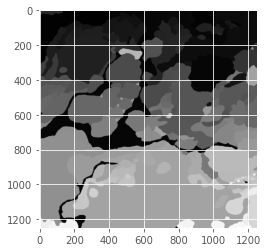

In [31]:
plt.imshow(label[0], cmap='gray')
plt.show()

In [6]:
# # Seperate the fixed and moving data
# moving = raw_data[:-1]
# fixed = raw_data[1:]

# # Set the label of fixed for segmentation/mask-->compare Dice result for evaluation
# label_moving = label[:-1]
# label_fixed = label[1:]

In [32]:
raw_data.shape

(125, 1250, 1250)

### **Resize**

In [9]:
def resize_img_keep_ratio(img, target_size, color=(255, 255, 255)):
    # img = cv2.imread(img_name)
    old_size = img.shape[0:2]
    # ratio = min(float(target_size)/(old_size))
    ratio = min(float(target_size[i]) / (old_size[i]) for i in range(len(old_size)))
    new_size = tuple([int(i * ratio) for i in old_size])
    img = cv2.resize(img, (new_size[1], new_size[0]))
    pad_w = target_size[1] - new_size[1]
    pad_h = target_size[0] - new_size[0]
    top, bottom = pad_h // 2, pad_h - (pad_h // 2)
    left, right = pad_w // 2, pad_w - (pad_w // 2)
    img_new = cv2.copyMakeBorder(img, top, bottom, left, right, cv2.BORDER_CONSTANT, None, color)
    return img_new 

In [10]:
# Resize the fixed images
a = []
for id in range(fixed.shape[0]):

  resized_input_f = resize_img_keep_ratio(fixed[id], (1024, 1024, 3))  
  a.append(resized_input_f)
resized_fixed = np.stack(a) 

NameError: name 'fixed' is not defined

In [ ]:
# Resize the moving images
b = []
for id in range(moving.shape[0]):
 
  resized_input_m = resize_img_keep_ratio(moving[id], (1024, 1024, 3))
  b.append(resized_input_m)
resized_moving = np.stack(b) 

In [ ]:
# Change the type of label from uint64 to uint8
label_fixed = label_fixed.astype('uint8') 
label_moving = label_moving.astype('uint8')  

In [ ]:
# Resize the label images
c = []
for idf in range(label_fixed.shape[0]):
 
  resized_label_f = resize_img_keep_ratio(label_fixed[idf], (1024, 1024, 3))
  c.append(resized_label_f)
resized_label_f = np.stack(c)



In [ ]:
d = []
for idm in range(label_moving.shape[0]):
 
  resized_label_m = resize_img_keep_ratio(label_moving[idm], (1024, 1024, 3))
  d.append(resized_label_m)
resized_label_m = np.stack(d)

### ***Patch***

In [7]:
# !pip install patchify

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com


In [33]:
"Patch into 4 pieces of each slice"

from patchify import patchify, unpatchify

patch_h = 256
patch_w = 256
patch_step = 256

In [34]:
m=[]
for i in range(raw_data.shape[0]):
    patches_img = patchify(raw_data[i], (patch_h,patch_w), step=patch_step) # split image into 2*3 small 2*2 patches.
    m.append(patches_img)
img_patches = np.stack(m)

n=[]
for i in range(label.shape[0]):
    patches_label = patchify(label[i], (patch_h,patch_w), step=patch_step) # split image into 2*3 small 2*2 patches.
    n.append(patches_label)
label_patches = np.stack(n)

In [ ]:
# # Patch label images
# m=[]
# for i in range(resized_label_f.shape[0]):
#   patches_label_fixed = patchify(resized_label_f[i], (patch_h,patch_w), step=patch_step) # split image into 2*3 small 2*2 patches.
#   m.append(patches_label_fixed)
# label_fixed_patches = np.stack(m)

# # Patch label moving
# n=[]
# for i in range(resized_label_m.shape[0]):
#   patches_label_moving = patchify(resized_label_m[i], (patch_h,patch_w), step=patch_step) # split image into 2*3 small 2*2 patches.
#   n.append(patches_label_moving)
# label_moving_patches = np.stack(n)

# # Patch fixed images
# fixed_n=[]
# for i in range(resized_fixed.shape[0]):
#   patches_fixed = patchify(resized_fixed[i], (patch_h,patch_w), step=patch_step) # split image into 2*3 small 2*2 patches.
#   fixed_n.append(patches_fixed)
# fixed_patches = np.stack(fixed_n)

# # Patch moving images
# moving_n=[]
# for i in range(resized_moving.shape[0]):
#   patches_moving = patchify(resized_moving[i], (patch_h,patch_w), step=patch_step) # split image into 2*3 small 2*2 patches.
#   moving_n.append(patches_moving)
# moving_patches = np.stack(moving_n)

In [35]:
patched_label = np.reshape(label_patches,(label_patches.shape[0] * label_patches.shape[1] * label_patches.shape[2], patch_h, patch_w))
patched_img = np.reshape(img_patches,(img_patches.shape[0] * img_patches.shape[1] * img_patches.shape[2], patch_h, patch_w))

In [ ]:
# # Reshape the each pathced image

# patched_label_fixed = np.reshape(label_fixed_patches,(label_fixed_patches.shape[0] * label_fixed_patches.shape[1] * label_fixed_patches.shape[2], patch_h, patch_w))
# patched_label_moving = np.reshape(label_moving_patches,(label_moving_patches.shape[0] * label_moving_patches.shape[1] * label_moving_patches.shape[2], patch_h, patch_w))
# patched_fixed = np.reshape(fixed_patches,(fixed_patches.shape[0] * fixed_patches.shape[1] * fixed_patches.shape[2], patch_h, patch_w))
# patched_moving = np.reshape(moving_patches,(moving_patches.shape[0] * moving_patches.shape[1] * moving_patches.shape[2], patch_h, patch_w))

In [36]:
print(patched_img.shape)

(2000, 256, 256)


In [37]:
patched_label

array([[[12420, 12420, 12420, ..., 10943, 10943, 10943],
        [12420, 12420, 12420, ..., 10943, 10943, 10943],
        [12420, 12420, 12420, ..., 10943, 10943, 10943],
        ...,
        [10958, 10958, 10958, ..., 12053, 12053, 12053],
        [10958, 10958, 10958, ..., 12053, 12053, 12053],
        [10958, 10958, 10958, ..., 12053, 12053, 12053]],

       [[10943, 10943, 10943, ..., 11068, 11068, 11068],
        [10943, 10943, 10943, ..., 11068, 11068, 11068],
        [10943, 10943, 10943, ..., 11068, 11068, 11068],
        ...,
        [12053, 12053, 12053, ..., 13661, 13661, 13661],
        [12053, 12053, 12053, ..., 13661, 13661, 13661],
        [12053, 12053, 12053, ..., 13661, 13661, 13661]],

       [[11068, 11068, 11068, ..., 11179, 11179, 11179],
        [11068, 11068, 11068, ..., 11179, 11179, 11179],
        [11068, 11068, 11068, ..., 11179, 11179, 11179],
        ...,
        [13661, 13661, 13661, ..., 12215, 12215, 12215],
        [13661, 13661, 13661, ..., 12215, 122

/tmp/ipykernel_37083/1854549394.py:2: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.
  plt.show()


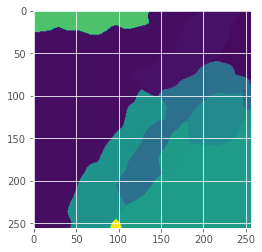

In [38]:
plt.imshow(patched_label[0])
plt.show()

In [39]:
# patched_label =  ( patched_label-patched_label[()].min() ) / (patched_label[()].max()-patched_label[()].min())

/tmp/ipykernel_37083/465120500.py:2: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.
  plt.show()


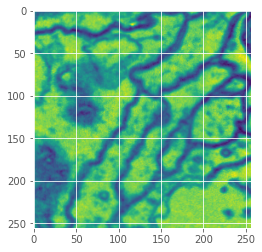

In [40]:
plt.imshow(patched_img[0])
plt.show()

/tmp/ipykernel_37083/2473625595.py:2: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.
  plt.show()


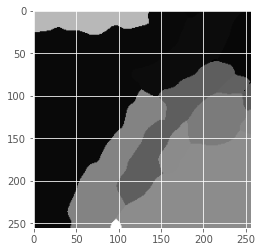

In [41]:
plt.imshow(patched_label[0],cmap='gray')
plt.show()

In [42]:
patched_label[0]

array([[12420, 12420, 12420, ..., 10943, 10943, 10943],
       [12420, 12420, 12420, ..., 10943, 10943, 10943],
       [12420, 12420, 12420, ..., 10943, 10943, 10943],
       ...,
       [10958, 10958, 10958, ..., 12053, 12053, 12053],
       [10958, 10958, 10958, ..., 12053, 12053, 12053],
       [10958, 10958, 10958, ..., 12053, 12053, 12053]], dtype=uint64)

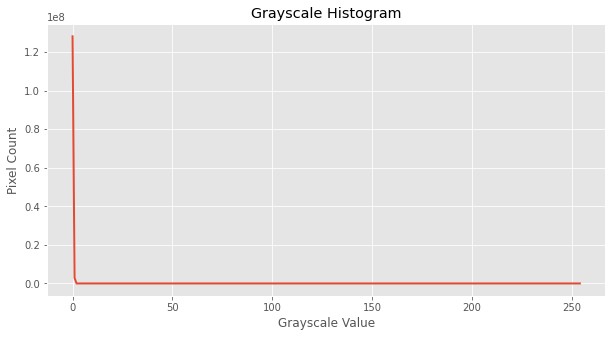

In [21]:
# Calculate histogram
num_bins = 256
histogram, bins = np.histogram(patched_label.flatten(), num_bins, range=(0, 255))

# Plot histogram
plt.figure(figsize=(10, 5))
plt.plot(bins[:-1], histogram, lw=2)
plt.title('Grayscale Histogram')
plt.xlabel('Grayscale Value')
plt.ylabel('Pixel Count')

# Show plot
plt.show()

In [22]:
binary_lbl_array = (patched_label >= 0.9).astype(np.uint8) #* 255

# # Convert the NumPy array to a PIL image to save it
# binary_image = Image.fromarray(binary_lbl_array)

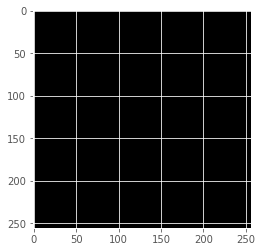

In [23]:
plt.imshow(binary_lbl_array[0], cmap='gray')
plt.show()

In [24]:
np.unique(binary_lbl_array[0])

array([0], dtype=uint8)

### **Elastic Moving**

In [17]:
from scipy.ndimage.interpolation import map_coordinates
from scipy.ndimage.filters import gaussian_filter

def elastic_transform(image, alpha, sigma, alpha_affine, random_state=None):
    """Elastic deformation of images as described in [Simard2003]_ (with modifications).
    .. [Simard2003] Simard, Steinkraus and Platt, "Best Practices for
         Convolutional Neural Networks applied to Visual Document Analysis", in
         Proc. of the International Conference on Document Analysis and
         Recognition, 2003.

     Based on https://gist.github.com/erniejunior/601cdf56d2b424757de5
    """
    if random_state is None:
        random_state = np.random.RandomState(None)
    shape = image.shape
    shape_size = shape[:2]
    
    # Random affine
    center_square = np.float32(shape_size) // 2
    square_size = min(shape_size) // 3
    pts1 = np.float32([center_square + square_size, [center_square[0]+square_size, center_square[1]-square_size], center_square - square_size])
    pts2 = pts1 + random_state.uniform(-alpha_affine, alpha_affine, size=pts1.shape).astype(np.float32)
    M = cv2.getAffineTransform(pts1, pts2)
    image = cv2.warpAffine(image, M, shape_size[::-1], borderMode=cv2.BORDER_REFLECT_101)

    dx = gaussian_filter((random_state.rand(*shape) * 2 - 1), sigma) * alpha
    dy = gaussian_filter((random_state.rand(*shape) * 2 - 1), sigma) * alpha
    dz = np.zeros_like(dx)

    x, y, z = np.meshgrid(np.arange(shape[1]), np.arange(shape[0]), np.arange(shape[2]))
    indices = np.reshape(y+dy, (-1, 1)), np.reshape(x+dx, (-1, 1)), np.reshape(z, (-1, 1))

    return map_coordinates(image, indices, order=1, mode='reflect').reshape(shape)

In [18]:
im_t_l=[]
im_mask_t_l=[]

for i in range(len(patched_moving)): 
  # Load images
  im = patched_moving[i]  
  im_mask = patched_label_moving[i] 

  # Merge images into separete channels (shape will be (cols, rols, 2))

  im_merge = np.concatenate((im[...,None], im_mask[...,None]), axis=2) 
  # Apply transformation on image
  im_merge_t = elastic_transform(im_merge, im_merge.shape[1] * 2, im_merge.shape[1] * 0.1, im_merge.shape[1] * 0.09)   #2,0.08, 0.08 augmentation以后dice结果并不好

  # Split image and mask
  im_t = im_merge_t[...,0]
  im_mask_t = im_merge_t[...,1] 

  im_t_l.append(im_t)
  im_mask_t_l.append(im_mask_t)
  
patched_elastic_moving = np.stack(im_t_l)
patched_label_elastic_moving = np.stack(im_mask_t_l)

In [19]:
print(patched_fixed.shape, patched_elastic_moving.shape)

(496, 512, 512) (496, 512, 512)


Text(0.5, 1.0, 'Moving image')

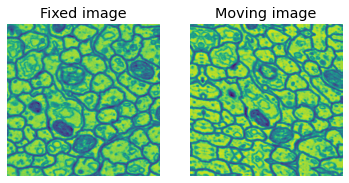

In [24]:
plt.subplot(1,2,1)
plt.imshow(patched_fixed[0])
plt.axis('off') 
plt.title('Fixed image')

plt.subplot(1,2,2)
plt.imshow(patched_elastic_moving[0])
plt.axis('off') 
plt.title('Moving image')

**Mask**

In [ ]:
# import h5py
# import numpy as np
# import scipy

# def create_border_mask(input_data, target, max_dist, background_label,axis=0):
#     """
#     Overlay a border mask with background_label onto input data.
#     A pixel is part of a border if one of its 4-neighbors has different label.
    
#     Parameters
#     ----------
#     input_data : h5py.Dataset or numpy.ndarray - Input data containing neuron ids
#     target : h5py.Datset or numpy.ndarray - Target which input data overlayed with border mask is written into.
#     max_dist : int or float - Maximum distance from border for pixels to be included into the mask.
#     background_label : int - Border mask will be overlayed using this label.
#     axis : int - Axis of iteration (perpendicular to 2d images for which mask will be generated)
#     """
#     sl = [slice(None) for d in range(len(target.shape))]

#     for z in range(target.shape[axis]):
#         sl[ axis ] = z
#         border = create_border_mask_2d(input_data[tuple(sl)], max_dist)
#         target_slice = input_data[tuple(sl)] if isinstance(input_data,h5py.Dataset) else np.copy(input_data[tuple(sl)]) 
#         target_slice[border] = background_label
#         target[tuple(sl)] = target_slice

# def create_border_mask_2d(image, max_dist):
#     """
#     Create binary border mask for image.
#     A pixel is part of a border if one of its 4-neighbors has different label.
    
#     Parameters
#     ----------
#     image : numpy.ndarray - Image containing integer labels.
#     max_dist : int or float - Maximum distance from border for pixels to be included into the mask.
#     Returns
#     -------
#     mask : numpy.ndarray - Binary mask of border pixels. Same shape as image.
#     """
#     max_dist = max(max_dist, 0)
    
#     padded = np.pad(image, 1, mode='edge')
    
#     border_pixels = np.logical_and(
#         np.logical_and( image == padded[:-2, 1:-1], image == padded[2:, 1:-1] ),
#         np.logical_and( image == padded[1:-1, :-2], image == padded[1:-1, 2:] )
#         )

#     distances = scipy.ndimage.distance_transform_edt(
#         border_pixels,
#         return_distances=True,
#         return_indices=False
#         )
# #
#     return distances <= max_dist

# target = np.zeros([448, 448], dtype=int) 
# create_border_mask(patched_label_fixed, target, 3, 240)

In [43]:
from tempfile import TemporaryFile
matplotlib.use('Agg') 
import scipy.ndimage as ndimage
from scipy.ndimage.interpolation import rotate 
import time
 
plt.style.use('ggplot')

"""
https://github.com/celisun/Deep_learning_automated__neuron_segmentation/blob/master/Train.py

"""

def mask_filtered(input, label, savename):
    """
    Image boudnary dilation
    Compute mask on each depth for un-selectable dilated(6X) boundary pixels (labeled as value 200.),
    the selectable background (0.) and actual boundary (100.) pixels
    return(numpy array): mask of shape 125,1250,1250
    """
    print("")
    print("")
    print('building mask from dataset...')
    since = time.time()

    d, h, w = input.shape
    # print(d,h,w)
    mask = np.empty([d, h, w]).astype('uint8')
    for i in range(d):
        for j in range(h):
            for k in range(w):
                pixel = label[i, j, k]
                if check_boundary(pixel, i, j, k, label):
                    mask[i, j, k] = 100
                else:
                    mask[i, j, k] = 0
        # if (i + 1) % 1 == 0:
            # print(str(0.8 * (i + 1)) + '% done')

    mask_dilated = ndimage.binary_dilation(mask, iterations=7).astype(mask.dtype)
    mask_filtered = 200 * mask_dilated - mask

    # filter_time = time.time()
    # time_elapsed = filter_time - since
    # print('Mask complete in {:.0f}m {:.0f}s'.format(
    #     time_elapsed // 60, time_elapsed % 60))


    # print('save to .npy file...')
    # np.save('/content/drive/MyDrive/voxelmorph_swin_unet_new/DATA_EM_NEW/mask_' + savename + '.npy', mask_filtered)
    # for mask_i in range(mask_filtered.shape[0]):
    #     path_mask = '/content/drive/MyDrive/voxelmorph_swin_unet_new/DATA_EM_NEW/mask_' + savename + '/'
    #     # print(path_mask)
    #     name_mask =  path_mask + savename + '_' + str(mask_i) + '.png' 	
    #     # print(name_mask)
    #     cv2.imwrite(os.path.join(name_mask), mask_filtered[mask_i])
    print('finished')
    return mask_filtered


def check_boundary(pixel, x, y, z, label):
    """
    Check if a pixel at position (x,y,z) is labeled
    as boundary/non-boundary in neuron_ids.
    return(boolean): boundary
    """
    max_z = label.shape[2] - 1
    max_y = label.shape[1] - 1
    a = label[x, y, z - 1] if z > 0 else pixel
    b = label[x, y, z + 1] if z < max_z else pixel
    c = label[x, y - 1, z] if y > 0 else pixel
    d = label[x, y + 1, z] if y < max_y else pixel
    e = label[x, y - 1, z - 1] if (y > 0 and z > 0) else pixel
    f = label[x, y - 1, z + 1] if (y > 0 and z < max_z) else pixel
    g = label[x, y + 1, z - 1] if (y < max_y and z > 0) else pixel
    h = label[x, y + 1, z + 1] if (y < max_y and z < max_z) else pixel

    neighbors = [a, b, c, d, e, f, g, h]
    boundary = False
    for neighbor in neighbors:
        if pixel != neighbor:
            boundary = True

    return boundary

/tmp/ipykernel_37083/1937596134.py:4: DeprecationWarning: Please use `rotate` from the `scipy.ndimage` namespace, the `scipy.ndimage.interpolation` namespace is deprecated.
  from scipy.ndimage.interpolation import rotate


In [44]:
def mask_binary(mask): 
  m_l=[]
  for i in range(len(mask)):
   
    mask_binary = mask[i] !=100
    # print(mask_binary)
    mask_b = mask_binary.astype(np.int)
    m_l.append(mask_b)
  m_s = np.stack(m_l, axis = 0)
  return m_s

In [45]:

######patched_fixed/patched_elastic_moving, patched_label_fixed/patched_label_elastic_moving, patched_mask_fixed/patched_mask_elastic_moving

savename = 'maskB' 
label = patched_label
mask = mask_filtered(patched_img, patched_label, savename)  # used only when the first time of training
print('mask fixed generated...')




building mask from dataset...
finished
mask fixed generated...


In [ ]:

# ######patched_fixed/patched_elastic_moving, patched_label_fixed/patched_label_elastic_moving, patched_mask_fixed/patched_mask_elastic_moving

# savename_f = 'fixed'
# input_f = patched_fixed
# label_f = patched_label_fixed
# mask_f = mask_filtered(input_f, label_f, savename_f)  # used only when the first time of training
# print('mask fixed generated...')

# savename_m = 'moving'
# # input_m = patched_elastic_moving
# # label_m = patched_label_elastic_moving
# input_m = patched_moving
# label_m = patched_label_moving
# mask_m = mask_filtered(input_m, label_m, savename_m) 
# print('mask moving generated...')



building mask from dataset...
finished
mask fixed generated...


building mask from dataset...
finished
mask moving generated...


In [ ]:
# mask_f_load = np.load('/content/drive/MyDrive/voxelmorph_swin_unet_new/DATA_EM_NEW/mask_' + savename_f + '.npy')
# mask_m_load = np.load('/content/drive/MyDrive/voxelmorph_swin_unet_new/DATA_EM_NEW/mask_' + savename_m + '.npy')
# print('loaded mask fixed and mask moving...')

In [46]:
mask_binary = mask_binary(mask)


/tmp/ipykernel_37083/754336516.py:7: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask_b = mask_binary.astype(np.int)


In [47]:
mask_b = mask_binary.astype(np.int)

/tmp/ipykernel_37083/2238344505.py:1: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask_b = mask_binary.astype(np.int)


/tmp/ipykernel_37083/3381298063.py:2: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.
  plt.show()


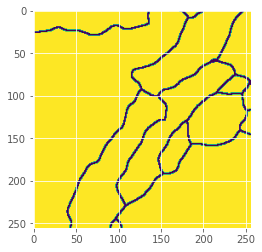

In [48]:
plt.imshow(mask_b[0])
plt.show()

In [49]:
print(np.unique(mask_b))

[0 1]


/tmp/ipykernel_37083/465120500.py:2: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.
  plt.show()


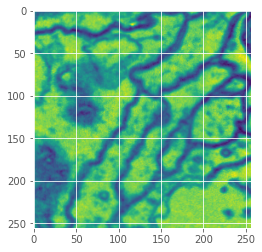

In [50]:
plt.imshow(patched_img[0])
plt.show()

In [ ]:
mask_binary_fixed = mask_binary(mask_f)
mask_binary_moving = mask_binary(mask_m)


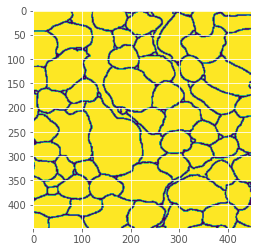

In [ ]:
plt.imshow(mask_binary_fixed[0])
plt.show()

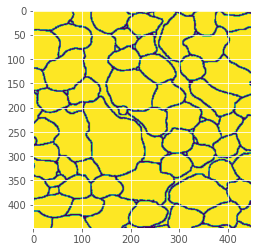

In [ ]:
plt.imshow(mask_binary_moving[0])
plt.show()

In [ ]:
print(np.unique(mask_binary_fixed))
print(np.unique(mask_binary_moving)) 

[0 1]
[0 1]


In [ ]:
mask_binary_fixed.dtype

dtype('int64')

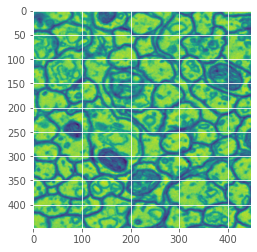

In [ ]:
plt.imshow(patched_fixed[0])
plt.show()

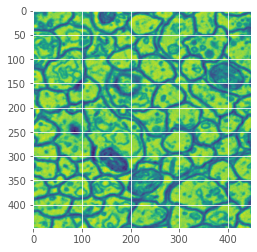

In [ ]:
plt.imshow(patched_moving[0])
plt.show()

**Save to file**

In [ ]:
# Save each patched image, just use it when first time
for il in range(mask_binary_fixed.shape[0]):
    path = '/content/drive/MyDrive/voxelmorph_swin_unet_new/DATA_EM_NEW_seq/mask_fixed/'
    name =  path + 'fixed_' + str(il) + '.png'
    # print('path name:', name)
    cv2.imwrite(os.path.join(name), mask_binary_fixed[il]*255)

for il in range(mask_binary_moving.shape[0]):
    path = '/content/drive/MyDrive/voxelmorph_swin_unet_new/DATA_EM_NEW_seq/mask_moving/'
    name =  path + 'moving_' + str(il) + '.png'
    # print('path name:', name)
    cv2.imwrite(os.path.join(name), mask_binary_moving[il]*255)

for i in range(patched_fixed.shape[0]):
    path = '/content/drive/MyDrive/voxelmorph_swin_unet_new/DATA_EM_NEW_seq/fixed_img/'
    name =  path + 'fixed_' + str(i) + '.png' 
    cv2.imwrite(os.path.join(name), patched_fixed[i])

# for j in range(patched_elastic_moving.shape[0]):
#     path_m = '/content/drive/MyDrive/voxelmorph_swin_unet_new/DATA_EM_NEW_seq/moving_img/'
#     name_m =  path_m + 'moving_' + str(j) + '.png' 
#     cv2.imwrite(os.path.join(name_m), patched_elastic_moving[j])

for j in range(patched_moving.shape[0]):
    path_m = '/content/drive/MyDrive/voxelmorph_swin_unet_new/DATA_EM_NEW_seq/moving_img/'
    name_m =  path_m + 'moving_' + str(j) + '.png' 
    cv2.imwrite(os.path.join(name_m), patched_moving[j])

In [58]:
# max_value = patched_label[()].max()
# min_value = patched_label[()].min()

In [59]:
# patched_label_norm = (patched_label - min_value) / (max_value - min_value)

[[0 0 1 ... 1 1 1]
 [0 0 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 ...
 [1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]]


/tmp/ipykernel_76007/2327570462.py:3: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.
  plt.show()


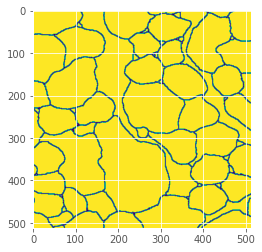

In [35]:
print(mask_binary[0])
plt.imshow(mask_binary[0])
plt.show()

In [51]:
for i in range(patched_img.shape[0]):
    path = '/home/kunzixie/Medical_Image_Analysis/cremi/img256C/'
    name =  path + 'patchedimg_' + str(i) + '.png'
    # print('path name:', name)
    cv2.imwrite(os.path.join(name), patched_img[i])

for il in range(mask_binary.shape[0]):
    path = '/home/kunzixie/Medical_Image_Analysis/cremi/mask256C/'
    name =  path + 'patchedmask_' + str(il) + '.png'
    # print('path name:', name)
    cv2.imwrite(os.path.join(name), mask_binary[il]*255)
    

In [52]:
print('End the images process!!!!')

End the images process!!!!


In [53]:
patched_img.shape

(2000, 256, 256)

### **VoxelMorph**

### **Evaluation**

In [ ]:
 # The evaluation Dice from original VoxelMorph paper
 
 def dice(array1, array2, labels=None, include_zero=False):
    """
    Computes the dice overlap between two arrays for a given set of integer labels.
    Parameters:
        array1: Input array 1.
        array2: Input array 2.
        labels: List of labels to compute dice on. If None, all labels will be used.
        include_zero: Include label 0 in label list. Default is False.
    """
    if labels is None:
        labels = np.concatenate([np.unique(a) for a in [array1, array2]])
        labels = np.sort(np.unique(labels))
    if not include_zero:
        labels = np.delete(labels, np.argwhere(labels == 0)) 

    dicem = np.zeros(len(labels))
    for idx, label in enumerate(labels):
        top = 2 * np.sum(np.logical_and(array1 == label, array2 == label))
        bottom = np.sum(array1 == label) + np.sum(array2 == label)
        bottom = np.maximum(bottom, np.finfo(float).eps)  # add epsilon
        dicem[idx] = top / bottom
    return dicem
 